In [2]:
import pandas as pd
import numpy as np
import baostock as bs
import matplotlib.pyplot as plt
import cvxpy as cp
import matplotlib
import scipy.stats as st
import pymc3 as pm
from matplotlib.ticker import FuncFormatter

matplotlib. rcParams['font.family']='SimHei'
matplotlib.rcParams['axes.unicode_minus'] =False

## Data Collection

In [4]:
#### 登陆系统 ####
lg = bs.login()
# 显示登陆返回信息
print('login respond error_code:'+lg.error_code)
print('login respond  error_msg:'+lg.error_msg)

df=pd.DataFrame()

code='sh.000300'
name='沪深300'

#### 获取沪深A股历史K线数据 ####
rs = bs.query_history_k_data_plus(code,"date,code,close",
    start_date='2005-01-01', end_date='2020-12-31',
    frequency="d", adjustflag="2")
print('query_history_k_data_plus respond error_code:'+rs.error_code)
print('query_history_k_data_plus respond  error_msg:'+rs.error_msg)

#### 打印结果集 ####
data_list = []
while (rs.error_code == '0') & rs.next():
    # 获取一条记录，将记录合并在一起
    data_list.append(rs.get_row_data())
result = pd.DataFrame(data_list, columns=rs.fields)

df[name]=result['close']

print('%s is finished'%name)

df['date']=result['date']

#### 登出系统 ####
bs.logout()

login success!
login respond error_code:0
login respond  error_msg:success
query_history_k_data_plus respond error_code:0
query_history_k_data_plus respond  error_msg:success
沪深300 is finished
logout success!


In [6]:
df['date']=pd.to_datetime(df['date'])
df['沪深300']=pd.to_numeric(df['沪深300'])
df=df.set_index('date')
df.head()

,沪深300
date,
2005-01-04,982.7940
2005-01-05,992.5640
2005-01-06,983.1740
2005-01-07,983.9580
2005-01-10,993.8790


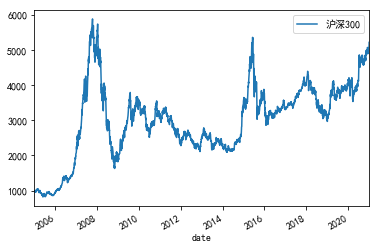

In [15]:
df.plot()
plt.show()

In [16]:
df.to_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\sh300.xlsx',encoding='utf-8',index=True,header=True)

In [3]:
df=pd.read_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\sh300.xlsx',index_col='date')
daily_return=np.log(df).diff().dropna()

In [9]:
def plot_with_sample_para(data,plot_ax,bin_num=50,normal_flag=1,degree_free=1):
    """
    Draw a normal plot or log-normal plot based on the shape of data
    
    Parameters
    ----------
    data : np.array
    bin_num : int
    normal_flag : 1 or 2
        1 for normal distribution, 2 for log-normal distribution, 3 for student-t distribution
    plot_ax: the ax for plotting

    Returns
    -------
    None
    """    
    if normal_flag==1:  # if the data is subject to normal distribution
        nrv = st.norm(loc=data.mean(), scale=data.std())
    elif normal_flag==2:  # if the data is subject to log-normal distribution
        nrv=st.lognorm(s=np.log(data).std(), loc=0, scale=np.exp(np.log(data).mean()))
    else:  # if the data is subject to student-t distribution
        nrv=st.t(loc=data.mean(),scale=data.std(),df=degree_free)
        
    x_arr=np.linspace(data.min(),data.max(),bin_num+1)
    para_dist=np.diff(nrv.cdf(x_arr))*len(data)
    interval=x_arr[1]-x_arr[0]
    plot_ax.hist(data, bins=bin_num)
    plot_ax.plot(x_arr[:-1]+0.5*interval,para_dist)
    
    return None

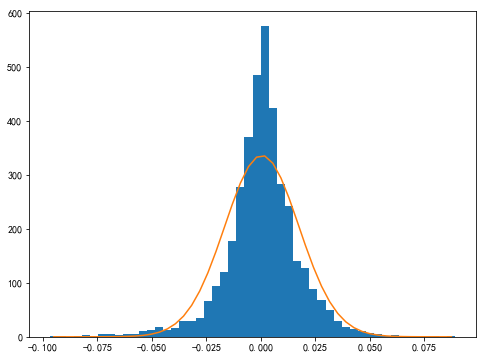

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_with_sample_para(daily_return.to_numpy(),plot_ax=ax,bin_num=50,degree_free=100,normal_flag=3)
plt.show()

## Build-in Period

In [6]:
quarterly_sigma=daily_return.loc[:'2017'].resample('Q').std()
quarterly_log_sigma=np.log(quarterly_sigma)
quarterly_log_sigma.diff().dropna().std()
#step_size_0=float(quarterly_log_sigma.diff().dropna().std())

Open     0.340551
Close    0.315634
dtype: float64

In [15]:
m = pm.Model()

with m:
    # Data
    data_returns = pm.Data("data_returns", daily_return.loc['2018':'2019','沪深300'].to_numpy())
    
    # Prior on the DoF
    nu = pm.Exponential("nu", 0.1)

    # Prior on the step size of GRW
    step_size = pm.Exponential("step_size", 1/step_size_0)

    # Prior on the volatility
    log_sigma = pm.GaussianRandomWalk("log_sigma", sigma=step_size, shape=daily_return.loc['2018':'2019'].shape[0])

    # Likelihood of returns
    obs_returns = pm.StudentT(
        "obs_returns", nu=nu, lam=pm.math.exp(-2*log_sigma), observed=data_returns
    )

In [16]:
with m:
    trace = pm.sample(200, tune=200)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 13855 seconds.
The acceptance probability does not match the target. It is 0.6949986807035659, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


E:\Anaconda\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000203336D9F28>,
      dtype=object)

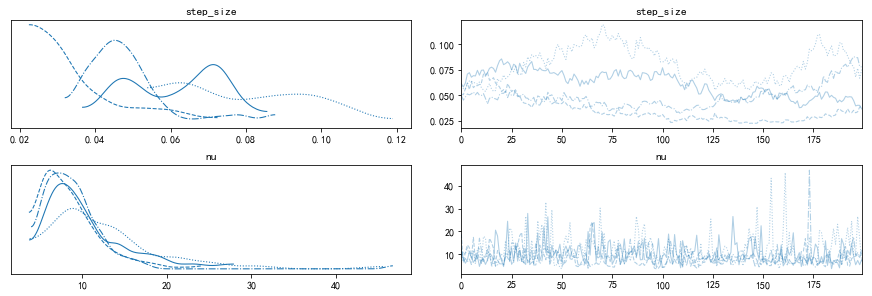

In [17]:
pm.traceplot(trace, var_names=["step_size", "nu"])

In [18]:
result=pd.DataFrame()
result['nu']=trace['nu']
result['step_size']=trace['step_size']

E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


In [19]:
pd.DataFrame(trace['log_sigma']).to_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\second_result_log_sigma.xlsx',encoding='utf-8',index=True,header=True)
result.to_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\second_result.xlsx',encoding='utf-8',index=True,header=True)

In [20]:
with m:
    posterior_predictive = pm.sample_posterior_predictive(trace)

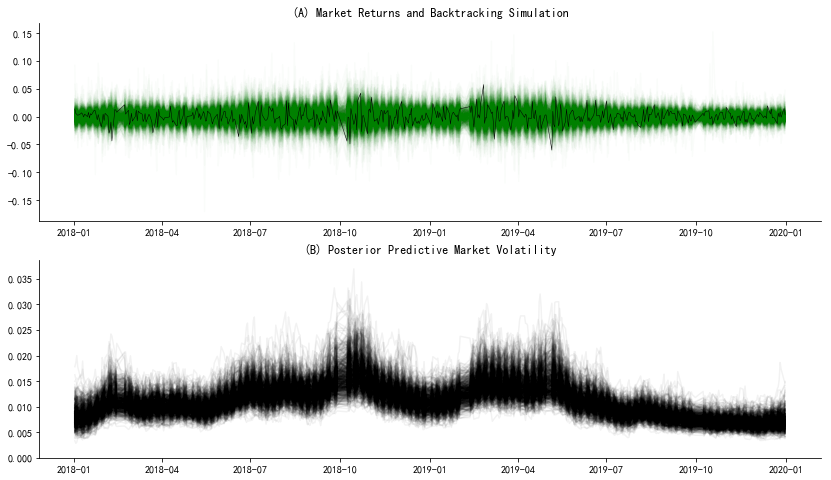

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(14, 8))

y_vals = np.exp(trace["log_sigma"]).T
x = daily_return.loc['2018':'2019'].index.to_numpy().astype(np.datetime64)
x_vals = np.vstack([daily_return.loc['2018':'2019'].index for _ in y_vals.T]).T.astype(np.datetime64)

# Plot daily_return.loc['2018':'2019']
ax[0].plot(
    x, posterior_predictive["obs_returns"].T, color="g",
    alpha=0.02, zorder=-10
)
ax[0].plot(x, daily_return.loc['2018':'2019'].to_numpy(), color="k", linewidth=0.5)
ax[0].spines['top'].set_visible(False)  
ax[0].spines['right'].set_visible(False)
ax[0].set_title('(A) Market Returns and Backtracking Simulation')

# # Plot volatility
y_vals = np.exp(trace["log_sigma"]).T

ax[1].plot(x, y_vals, "k", alpha=0.05)
ax[1].set_ylim(bottom=0)
ax[1].spines['top'].set_visible(False)  
ax[1].spines['right'].set_visible(False)
ax[1].set_title('(B) Posterior Predictive Market Volatility')
plt.show()

fig.savefig('Market Returns and Volatility.pdf',bb_inches='tight')

In [7]:
result=pd.read_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\Build-in Result\\second_result.xlsx')

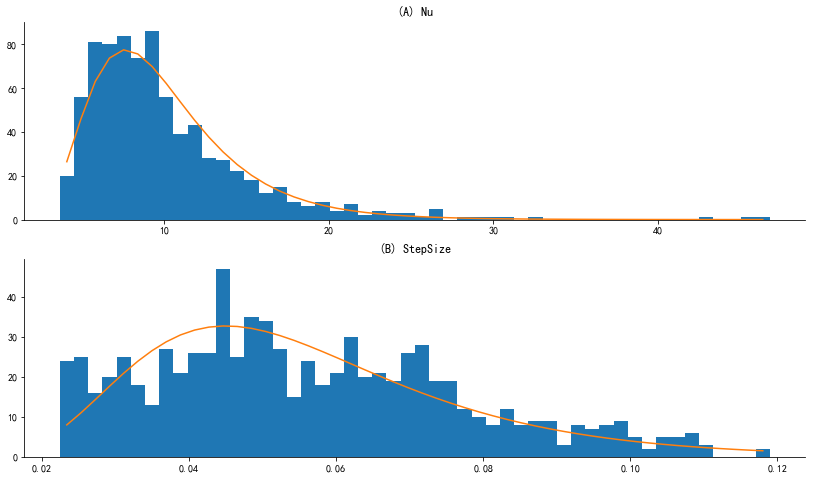

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(14, 8))
plot_with_sample_para(result['nu'],plot_ax=ax[0],bin_num=50,normal_flag=2,degree_free=1)
ax[0].spines['top'].set_visible(False) 
ax[0].spines['right'].set_visible(False)
ax[0].set_title('(A) Nu')

plot_with_sample_para(result['step_size'],plot_ax=ax[1],bin_num=50,normal_flag=2,degree_free=1)
ax[1].spines['top'].set_visible(False) 
ax[1].spines['right'].set_visible(False)
ax[1].set_title('(B) StepSize')

plt.show()

fig.savefig('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\figures\\Posterior Predictive of Build-in Period.pdf',bb_inches='tight')

In [29]:
result.mean()

nu           10.057861
step_size     0.056257
dtype: float64

## VaR Computation

In [7]:
result_df=pd.read_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\Build-in Result\\second_result.xlsx',index=True)
log_sigma_df=pd.read_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\Build-in Result\\second_result_log_sigma.xlsx')

In [48]:
result_df['log_sigma']=log_sigma_df.loc[:,486]

In [8]:
def generation(x):
    log_sigma_new=x[2]+x[1]*np.random.randn()
    dist=st.t(loc=0,scale=np.exp(log_sigma_new),df=x[0])
    return dist.rvs()

In [9]:
def VaR_draw(return_array,level=0.05):
    return_array.sort()
    return -(return_array[int(len(return_array)*0.05)-1])

In [10]:
def VaR_simulation(result_df,simulation_num=30000,VaR_level=0.05):
    index_array=np.random.choice(len(result_df),size=simulation_num,replace=True)
    para_set=result_df.loc[index_array,:]
    return_predictive=para_set.apply(generation,axis=1)
    return VaR_draw(np.array(return_predictive),level=VaR_level)

### First Quarter 2020

In [52]:
VaR_list=[]
VaR_list.append(VaR_simulation(result_df))

nu_path=pd.DataFrame()
step_size_path=pd.DataFrame()
log_sigma_path=pd.DataFrame()

In [53]:
timeline=daily_return.loc['2020Q1'].index

for date in timeline:
    print(date.strftime('%Y-%m-%d')+' is started')
    model = pm.Model()
    with model:
        # Data
        data_returns = pm.Data("data_returns", float(daily_return.loc[date].values))

        # Prior on the DoF
        nu = pm.Lognormal("nu", mu=float(np.log(result_df['nu']).mean()), sigma= float(np.log(result_df['nu']).std()))

        # Prior on the step size of GRW
        step_size = pm.Lognormal("step_size", mu=float(np.log(result_df['step_size']).mean()), sigma= float(np.log(result_df['step_size']).std()))

        # Prior on the volatility
        log_sigma = pm.Normal("log_sigma", float(result_df['log_sigma'].mean()),step_size)

        # Likelihood of returns
        obs_returns = pm.StudentT(
            "obs_returns", nu=nu, lam=pm.math.exp(-2*log_sigma), observed=data_returns)
        trace = pm.sample(1000, tune=1500)
        
    result_df=pd.DataFrame()
    result_df['nu']=trace['nu']
    result_df['step_size']=trace['step_size']
    result_df['log_sigma']=trace['log_sigma']
    
    nu_path[date]=trace['nu']
    step_size_path[date]=trace['step_size']
    log_sigma_path[date]=trace['log_sigma']
    
    VaR_list.append(VaR_simulation(result_df))

2020-01-02 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 63 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-01-03 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 50 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-01-06 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 51 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8847440609621079, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-01-07 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 51 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-01-08 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 52 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-01-09 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 52 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-01-10 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 51 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-01-13 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 51 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-01-14 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 53 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-01-15 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 53 seconds.
The acceptance probability does not match the target. It is 0.8796633187980415, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-01-16 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 53 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-01-17 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 55 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-01-20 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 53 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-01-21 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 52 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6714103042362269, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-01-22 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 53 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-01-23 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 55 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7108131288583514, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-02-03 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 52 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6201117359792558, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-02-04 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 53 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-02-05 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 52 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-02-06 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 55 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-02-07 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 54 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-02-10 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 53 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.909672246515328, but should be close to 0.8. Try to increase the number of tuning steps.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-02-11 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 54 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-02-12 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 54 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-02-13 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 52 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-02-14 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 52 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-02-17 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 55 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-02-18 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 54 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-02-19 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 55 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-02-20 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 55 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8823875001425247, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-02-21 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 55 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8909061901230932, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-02-24 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 53 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6940280390188696, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-02-25 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 56 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-02-26 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 55 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6934519450294844, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-02-27 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 55 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-02-28 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 56 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-03-02 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 56 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-03-03 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 55 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-03-04 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 56 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-03-05 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 55 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-03-06 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 55 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-03-09 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 55 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-03-10 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 56 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-03-11 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 56 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-03-12 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 55 seconds.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7094579591122199, but should be close to 0.8. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-03-13 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 56 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-03-16 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 58 seconds.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 596 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.12607060654580543, but should be close to 0.8. Try to increase the number of tuning steps.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-03-17 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 68 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6739937089966604, but should be close to 0.8. Try to increase the number of tuning steps.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-03-18 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 54 seconds.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6597986766340146, but should be close to 0.8. Try to increase the number of tuning steps.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-03-19 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 59 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-03-20 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 58 seconds.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7181525588201343, but should be close to 0.8. Try to increase the number of tuning steps.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-03-23 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 57 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8872607179136043, but should be close to 0.8. Try to increase the number of tuning steps.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-03-24 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 56 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7140464173547245, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-03-25 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 57 seconds.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.628874146353408, but should be close to 0.8. Try to increase the number of tuning steps.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.884334808731078, but should be close to 0.8. Try to increase the number of tuning steps.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_va

2020-03-26 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 57 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-03-27 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 57 seconds.
There were 159 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6034842479770817, but should be close to 0.8. Try to increase the number of tuning steps.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8949568117502872, but should be close to 0.8. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_

2020-03-30 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 57 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-03-31 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 57 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6687924321890014, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


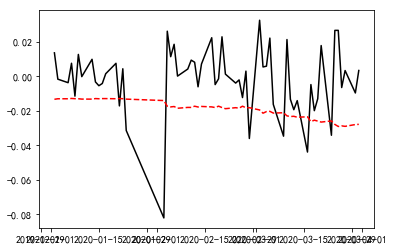

In [59]:
plt.plot(daily_return.loc[timeline].index,daily_return.loc[timeline],color='k')
plt.plot(timeline,-np.array(VaR_list[:-1]),color='red',linestyle='--')
plt.show()

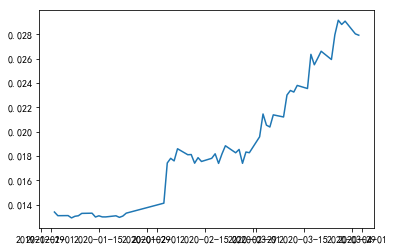

In [55]:
plt.plot(timeline,VaR_list[:-1])
plt.show()

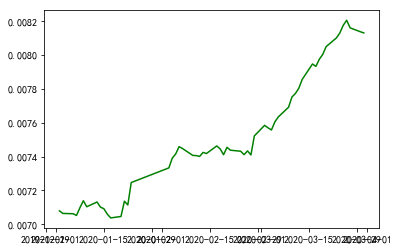

In [56]:
plt.plot(timeline,np.exp(log_sigma_path).mean(),color='g')
plt.show()

In [57]:
df_Q1=pd.DataFrame(index=daily_return.loc['2020Q1'].index)
df_Q1['Market Returns']=daily_return.loc['2020Q1']
df_Q1['VaR']=VaR_list[:-1]
df_Q1['sigma_mean']=np.exp(log_sigma_path).mean()

In [58]:
df_Q1.to_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\VaR and Sigma of 2020 Q1.xlsx',encoding='utf-8',index=True,header=True)
nu_path.to_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\Nu of 2020 Q1.xlsx',encoding='utf-8',index=False,header=True)
step_size_path.to_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\Step Size of 2020 Q1.xlsx',encoding='utf-8',index=False,header=True)
log_sigma_path.to_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\Log Sigma of 2020 Q1.xlsx',encoding='utf-8',index=False,header=True)

### Second Quarter 2020

In [20]:
nu_path_Q1=pd.read_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\Nu of 2020 Q1.xlsx')
step_size_path_Q1=pd.read_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\Step Size of 2020 Q1.xlsx')
log_sigma_path_Q1=pd.read_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\Log Sigma of 2020 Q1.xlsx')

In [21]:
end_of_march=nu_path_Q1.columns[-1]
result_df=pd.DataFrame()
result_df['nu']=nu_path_Q1[end_of_march]
result_df['step_size']=step_size_path_Q1[end_of_march]
result_df['log_sigma']=log_sigma_path_Q1[end_of_march]

In [24]:
# Q2
VaR_list=[]
VaR_list.append(VaR_simulation(result_df))
nu_path=pd.DataFrame()
step_size_path=pd.DataFrame()
log_sigma_path=pd.DataFrame()

timeline=daily_return.loc['2020Q2'].index

for date in timeline:
    print(date.strftime('%Y-%m-%d')+' is started')
    model = pm.Model()
    with model:
        # Data
        data_returns = pm.Data("data_returns", float(daily_return.loc[date].values))

        # Prior on the DoF
        nu = pm.Lognormal("nu", mu=float(np.log(result_df['nu']).mean()), sigma= float(np.log(result_df['nu']).std()))

        # Prior on the step size of GRW
        step_size = pm.Lognormal("step_size", mu=float(np.log(result_df['step_size']).mean()), sigma= float(np.log(result_df['step_size']).std()))

        # Prior on the volatility
        log_sigma = pm.Normal("log_sigma", float(result_df['log_sigma'].mean()),step_size)

        # Likelihood of returns
        obs_returns = pm.StudentT(
            "obs_returns", nu=nu, lam=pm.math.exp(-2*log_sigma), observed=data_returns)
        trace = pm.sample(1000, tune=1500)
        
    result_df=pd.DataFrame()
    result_df['nu']=trace['nu']
    result_df['step_size']=trace['step_size']
    result_df['log_sigma']=trace['log_sigma']
    
    nu_path[date]=trace['nu']
    step_size_path[date]=trace['step_size']
    log_sigma_path[date]=trace['log_sigma']
    
    VaR_list.append(VaR_simulation(result_df))

2020-04-01 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 61 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-04-02 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 61 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-04-03 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 64 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-04-07 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 57 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8958545216443038, but should be close to 0.8. Try to increase the number of tuning steps.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7159280341910362, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_

2020-04-08 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 55 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-04-09 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 57 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-04-10 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 55 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6260661042297467, but should be close to 0.8. Try to increase the number of tuning steps.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-04-13 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 55 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-04-14 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 56 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-04-15 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 55 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-04-16 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 55 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-04-17 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 57 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-04-20 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 55 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-04-21 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 55 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-04-22 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 56 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-04-23 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 56 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7009599999020522, but should be close to 0.8. Try to increase the number of tuning steps.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6624211293487142, but should be close to 0.8. Try to increase the number of tuning steps.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_

2020-04-24 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 56 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-04-27 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 56 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6799596545420891, but should be close to 0.8. Try to increase the number of tuning steps.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.659095413616853, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_

2020-04-28 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 64 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-04-29 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 55 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-04-30 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 55 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6737636716091354, but should be close to 0.8. Try to increase the number of tuning steps.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-05-06 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 55 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8897210957028143, but should be close to 0.8. Try to increase the number of tuning steps.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-05-07 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 59 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7198640348484869, but should be close to 0.8. Try to increase the number of tuning steps.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-05-08 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 56 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6827761331422171, but should be close to 0.8. Try to increase the number of tuning steps.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-05-11 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 58 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-05-12 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 56 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-05-13 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 56 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7141097160505874, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-05-14 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 55 seconds.
The acceptance probability does not match the target. It is 0.9019986869639381, but should be close to 0.8. Try to increase the number of tuning steps.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-05-15 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 54 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-05-18 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 55 seconds.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6011492814156438, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-05-19 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 54 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-05-20 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 54 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-05-21 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 54 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-05-22 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 54 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-05-25 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 55 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7001381108711664, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-05-26 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 54 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-05-27 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 56 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7007307895871759, but should be close to 0.8. Try to increase the number of tuning steps.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-05-28 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 57 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-05-29 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 56 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6108589133993787, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-06-01 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 56 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6528735869389751, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-06-02 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 55 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-06-03 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 56 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7085441983754306, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-06-04 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 63 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-06-05 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 56 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7200931627361671, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-06-08 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 56 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6807951763575687, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-06-09 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 58 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-06-10 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 59 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7123609984170313, but should be close to 0.8. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-06-11 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 59 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-06-12 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 60 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-06-15 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 59 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-06-16 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 60 seconds.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-06-17 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 63 seconds.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6995575845939483, but should be close to 0.8. Try to increase the number of tuning steps.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-06-18 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 61 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-06-19 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 63 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6450578617189576, but should be close to 0.8. Try to increase the number of tuning steps.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5979815623166307, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get

2020-06-22 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 60 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-06-23 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 59 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-06-24 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 58 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7150678262376478, but should be close to 0.8. Try to increase the number of tuning steps.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-06-29 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 58 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5760531144855541, but should be close to 0.8. Try to increase the number of tuning steps.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-06-30 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 60 seconds.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


E:\Anaconda\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


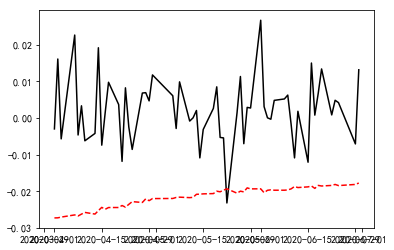

In [25]:
plt.plot(daily_return.loc[timeline].index,daily_return.loc[timeline],color='k')
plt.plot(timeline,-np.array(VaR_list[:-1]),color='red',linestyle='--')
plt.show()

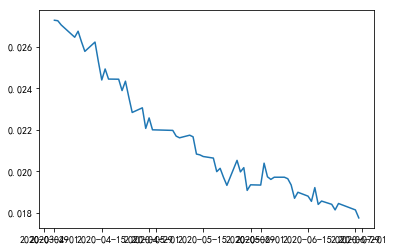

In [26]:
plt.plot(timeline,VaR_list[:-1])
plt.show()

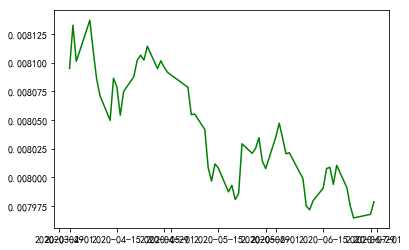

In [27]:
plt.plot(timeline,np.exp(log_sigma_path).mean(),color='g')
plt.show()

In [28]:
df_Q2=pd.DataFrame(index=daily_return.loc['2020Q2'].index)
df_Q2['Market Returns']=daily_return.loc['2020Q2']
df_Q2['VaR']=VaR_list[:-1]
df_Q2['sigma_mean']=np.exp(log_sigma_path).mean()

In [29]:
df_Q2.to_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\VaR and Sigma of 2020 Q2.xlsx',encoding='utf-8',index=True,header=True)
nu_path.to_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\Nu of 2020 Q2.xlsx',encoding='utf-8',index=False,header=True)
step_size_path.to_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\Step Size of 2020 Q2.xlsx',encoding='utf-8',index=False,header=True)
log_sigma_path.to_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\Log Sigma of 2020 Q2.xlsx',encoding='utf-8',index=False,header=True)

### Third Quarter 2020

In [30]:
# Q3
last_VaR_value=VaR_list[-1]
VaR_list=[]
VaR_list.append(last_VaR_value)
nu_path=pd.DataFrame()
step_size_path=pd.DataFrame()
log_sigma_path=pd.DataFrame()

timeline=daily_return.loc['2020Q3'].index

for date in timeline:
    print(date.strftime('%Y-%m-%d')+' is started')
    model = pm.Model()
    with model:
        # Data
        data_returns = pm.Data("data_returns", float(daily_return.loc[date].values))

        # Prior on the DoF
        nu = pm.Lognormal("nu", mu=float(np.log(result_df['nu']).mean()), sigma= float(np.log(result_df['nu']).std()))

        # Prior on the step size of GRW
        step_size = pm.Lognormal("step_size", mu=float(np.log(result_df['step_size']).mean()), sigma= float(np.log(result_df['step_size']).std()))

        # Prior on the volatility
        log_sigma = pm.Normal("log_sigma", float(result_df['log_sigma'].mean()),step_size)

        # Likelihood of returns
        obs_returns = pm.StudentT(
            "obs_returns", nu=nu, lam=pm.math.exp(-2*log_sigma), observed=data_returns)
        trace = pm.sample(1000, tune=1500)
        
    result_df=pd.DataFrame()
    result_df['nu']=trace['nu']
    result_df['step_size']=trace['step_size']
    result_df['log_sigma']=trace['log_sigma']
    
    nu_path[date]=trace['nu']
    step_size_path[date]=trace['step_size']
    log_sigma_path[date]=trace['log_sigma']
    
    VaR_list.append(VaR_simulation(result_df))

2020-07-01 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 81 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6094568844579669, but should be close to 0.8. Try to increase the number of tuning steps.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-07-02 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 70 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6684480517956671, but should be close to 0.8. Try to increase the number of tuning steps.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-07-03 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 62 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-07-06 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 63 seconds.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6987654006685241, but should be close to 0.8. Try to increase the number of tuning steps.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-07-07 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 63 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-07-08 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 61 seconds.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6604082249229409, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-07-09 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 63 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.663868200967981, but should be close to 0.8. Try to increase the number of tuning steps.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-07-10 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 67 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-07-13 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 65 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-07-14 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 60 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 96 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.602893529421477, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-07-15 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 62 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7208930729459749, but should be close to 0.8. Try to increase the number of tuning steps.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-07-16 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 59 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-07-17 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 64 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-07-20 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 64 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-07-21 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 63 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-07-22 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 65 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8908471123993104, but should be close to 0.8. Try to increase the number of tuning steps.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-07-23 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 61 seconds.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6242292191586408, but should be close to 0.8. Try to increase the number of tuning steps.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-07-24 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 62 seconds.
The acceptance probability does not match the target. It is 0.904209073651667, but should be close to 0.8. Try to increase the number of tuning steps.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-07-27 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 62 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-07-28 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 62 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7157096501718928, but should be close to 0.8. Try to increase the number of tuning steps.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-07-29 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 60 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.712241204655708, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-07-30 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 60 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7059177551752959, but should be close to 0.8. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-07-31 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 63 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-08-03 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 65 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-08-04 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 62 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-08-05 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 63 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-08-06 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 60 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-08-07 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 62 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6469894763836788, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8804244956887154, but should be close to 0.8. Try to increase the number of tuning steps.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_va

2020-08-10 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 60 seconds.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5212211602652406, but should be close to 0.8. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-08-11 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 62 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6619546013488957, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-08-12 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 61 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-08-13 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 61 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-08-14 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 62 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7038932604812772, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-08-17 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 61 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-08-18 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 61 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-08-19 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 62 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6970737741746561, but should be close to 0.8. Try to increase the number of tuning steps.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-08-20 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 60 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8908226395916362, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-08-21 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 59 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-08-24 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 62 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6927202233932247, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-08-25 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 59 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-08-26 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 60 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8851417197875601, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-08-27 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 59 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-08-28 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 61 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-08-31 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 59 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-09-01 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 61 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7063143651633266, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-09-02 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 60 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-09-03 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 62 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-09-04 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 60 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9000399952186798, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-09-07 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 59 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-09-08 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 62 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-09-09 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 61 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-09-10 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 65 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8829680806294093, but should be close to 0.8. Try to increase the number of tuning steps.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-09-11 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 63 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6937932795784989, but should be close to 0.8. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-09-14 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 62 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7060289713038251, but should be close to 0.8. Try to increase the number of tuning steps.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-09-15 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 61 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-09-16 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 63 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-09-17 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 64 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6717681237885559, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-09-18 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 64 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6785642356737545, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-09-21 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 68 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-09-22 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 66 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-09-23 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 65 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5855920452045348, but should be close to 0.8. Try to increase the number of tuning steps.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7116600532709568, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get

2020-09-24 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 62 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-09-25 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 67 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-09-28 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 65 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7045411009751171, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-09-29 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 67 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-09-30 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 66 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6746376412525512, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


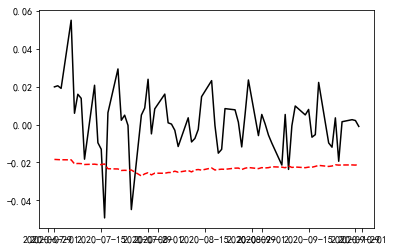

In [32]:
plt.plot(daily_return.loc[timeline].index,daily_return.loc[timeline],color='k')
plt.plot(timeline,-np.array(VaR_list[:-1]),color='red',linestyle='--')
plt.show()

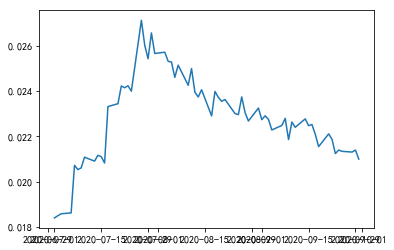

In [33]:
plt.plot(timeline,VaR_list[:-1])
plt.show()

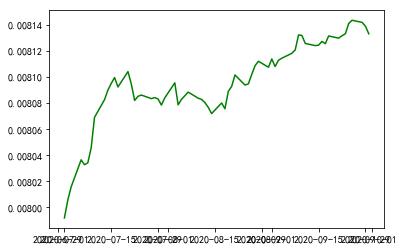

In [31]:
plt.plot(timeline,np.exp(log_sigma_path).mean(),color='g')
plt.show()

In [34]:
df_Q3=pd.DataFrame(index=daily_return.loc['2020Q3'].index)
df_Q3['Market Returns']=daily_return.loc['2020Q3']
df_Q3['VaR']=VaR_list[:-1]
df_Q3['sigma_mean']=np.exp(log_sigma_path).mean()

In [35]:
df_Q3.to_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\VaR and Sigma of 2020 Q3.xlsx',encoding='utf-8',index=True,header=True)
nu_path.to_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\Nu of 2020 Q3.xlsx',encoding='utf-8',index=False,header=True)
step_size_path.to_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\Step Size of 2020 Q3.xlsx',encoding='utf-8',index=False,header=True)
log_sigma_path.to_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\Log Sigma of 2020 Q3.xlsx',encoding='utf-8',index=False,header=True)

### Fourth Quarter

In [36]:
# Q3
last_VaR_value=VaR_list[-1]
VaR_list=[]
VaR_list.append(last_VaR_value)
nu_path=pd.DataFrame()
step_size_path=pd.DataFrame()
log_sigma_path=pd.DataFrame()

timeline=daily_return.loc['2020Q4'].index

for date in timeline:
    print(date.strftime('%Y-%m-%d')+' is started')
    model = pm.Model()
    with model:
        # Data
        data_returns = pm.Data("data_returns", float(daily_return.loc[date].values))

        # Prior on the DoF
        nu = pm.Lognormal("nu", mu=float(np.log(result_df['nu']).mean()), sigma= float(np.log(result_df['nu']).std()))

        # Prior on the step size of GRW
        step_size = pm.Lognormal("step_size", mu=float(np.log(result_df['step_size']).mean()), sigma= float(np.log(result_df['step_size']).std()))

        # Prior on the volatility
        log_sigma = pm.Normal("log_sigma", float(result_df['log_sigma'].mean()),step_size)

        # Likelihood of returns
        obs_returns = pm.StudentT(
            "obs_returns", nu=nu, lam=pm.math.exp(-2*log_sigma), observed=data_returns)
        trace = pm.sample(1000, tune=1500)
        
    result_df=pd.DataFrame()
    result_df['nu']=trace['nu']
    result_df['step_size']=trace['step_size']
    result_df['log_sigma']=trace['log_sigma']
    
    nu_path[date]=trace['nu']
    step_size_path[date]=trace['step_size']
    log_sigma_path[date]=trace['log_sigma']
    
    VaR_list.append(VaR_simulation(result_df))

2020-10-09 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 82 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-10-12 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 71 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.676003389847039, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-10-13 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 78 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-10-14 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 66 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-10-15 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 66 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 104 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.594491062473215, but should be close to 0.8. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-10-16 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 68 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-10-19 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 69 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 149 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5796328568708713, but should be close to 0.8. Try to increase the number of tuning steps.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-10-20 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 69 seconds.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6349907391765142, but should be close to 0.8. Try to increase the number of tuning steps.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6504394318178172, but should be close to 0.8. Try to increase the number of tuning steps.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get

2020-10-21 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 69 seconds.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6178498623469748, but should be close to 0.8. Try to increase the number of tuning steps.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.626590180867165, but should be close to 0.8. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_v

2020-10-22 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 65 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6301053449769397, but should be close to 0.8. Try to increase the number of tuning steps.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6962975004461301, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get

2020-10-23 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 72 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-10-26 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 69 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-10-27 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 74 seconds.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6845095696791698, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-10-28 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 71 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-10-29 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 71 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6838068967241847, but should be close to 0.8. Try to increase the number of tuning steps.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-10-30 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 87 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-11-02 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 71 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9017836843122827, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-11-03 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 74 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-11-04 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 69 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 128 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6616069445209427, but should be close to 0.8. Try to increase the number of tuning steps.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-11-05 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 75 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7023123677150017, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-11-06 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 70 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-11-09 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 73 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.683107939036161, but should be close to 0.8. Try to increase the number of tuning steps.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-11-10 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 70 seconds.
There were 104 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6401213644866329, but should be close to 0.8. Try to increase the number of tuning steps.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-11-11 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 77 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-11-12 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 76 seconds.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6346377109068169, but should be close to 0.8. Try to increase the number of tuning steps.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6917995198065284, but should be close to 0.8. Try to increase the number of tuning steps.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use

2020-11-13 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 77 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-11-16 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 82 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-11-17 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 75 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-11-18 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 80 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-11-19 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 76 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6640845160406939, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-11-20 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 75 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.715163456897594, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-11-23 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 74 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-11-24 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 73 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-11-25 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 77 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.881310923546899, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-11-26 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 83 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-11-27 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 74 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6988242813002752, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-11-30 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 77 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-12-01 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 73 seconds.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7174374910524907, but should be close to 0.8. Try to increase the number of tuning steps.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-12-02 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 77 seconds.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7078161807029544, but should be close to 0.8. Try to increase the number of tuning steps.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7122021243606338, but should be close to 0.8. Try to increase the number of tuning steps.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6469082388319262, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\p

2020-12-03 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 75 seconds.
There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5988444672954966, but should be close to 0.8. Try to increase the number of tuning steps.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6849452315411053, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.ge

2020-12-04 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 80 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-12-07 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 76 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-12-08 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 79 seconds.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6932590090425333, but should be close to 0.8. Try to increase the number of tuning steps.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-12-09 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 75 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7072439758158993, but should be close to 0.8. Try to increase the number of tuning steps.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6918803791232834, but should be close to 0.8. Try to increase the number of tuning steps.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get

2020-12-10 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 77 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-12-11 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 77 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6958893705203801, but should be close to 0.8. Try to increase the number of tuning steps.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-12-14 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 75 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 156 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5448916625968877, but should be close to 0.8. Try to increase the number of tuning steps.
There were 105 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5672019466518129, but should be close to 0.8. Try to increase the number of tuning steps.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.g

2020-12-15 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 82 seconds.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 161 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.608843212990681, but should be close to 0.8. Try to increase the number of tuning steps.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6946394330133431, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use

2020-12-16 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 81 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 159 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5731637771683954, but should be close to 0.8. Try to increase the number of tuning steps.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-12-17 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 76 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 368 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.44960867641796015, but should be close to 0.8. Try to increase the number of tuning steps.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_sta

2020-12-18 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 81 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 119 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6544828587533934, but should be close to 0.8. Try to increase the number of tuning steps.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-12-21 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 82 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6695712921532367, but should be close to 0.8. Try to increase the number of tuning steps.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 96 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6695624126784544, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get

2020-12-22 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 79 seconds.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7180752136764319, but should be close to 0.8. Try to increase the number of tuning steps.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6980641747548547, but should be close to 0.8. Try to increase the number of tuning steps.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get

2020-12-23 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 78 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-12-24 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 80 seconds.
There were 104 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6767452639231194, but should be close to 0.8. Try to increase the number of tuning steps.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-12-25 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 76 seconds.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6127671958804355, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-12-28 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 79 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6040993456781175, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-12-29 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 73 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6867900153569185, but should be close to 0.8. Try to increase the number of tuning steps.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_values or trace.get_sampler_stats.
  "Attribute access on a trace object is ambigous. "


2020-12-30 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 82 seconds.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6769866790905688, but should be close to 0.8. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 174 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4651626877185295, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get_

2020-12-31 is started


E:\Anaconda\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, step_size, nu]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 74 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6902334904769437, but should be close to 0.8. Try to increase the number of tuning steps.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6866071409325593, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
E:\Anaconda\lib\site-packages\pymc3\backends\base.py:339: UserWarning: Attribute access on a trace object is ambigous. Sampler statistic and model variable share a name. Use trace.get

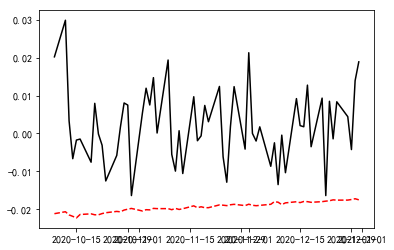

In [37]:
plt.plot(daily_return.loc[timeline].index,daily_return.loc[timeline],color='k')
plt.plot(timeline,-np.array(VaR_list[:-1]),color='red',linestyle='--')
plt.show()

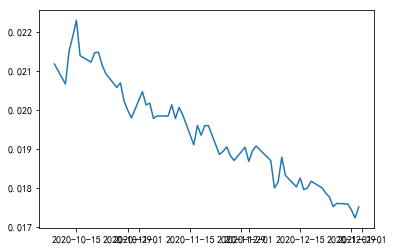

In [38]:
plt.plot(timeline,VaR_list[:-1])
plt.show()

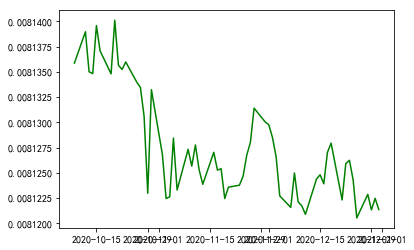

In [39]:
plt.plot(timeline,np.exp(log_sigma_path).mean(),color='g')
plt.show()

In [40]:
df_Q4=pd.DataFrame(index=daily_return.loc['2020Q4'].index)
df_Q4['Market Returns']=daily_return.loc['2020Q4']
df_Q4['VaR']=VaR_list[:-1]
df_Q4['sigma_mean']=np.exp(log_sigma_path).mean()

In [41]:
df_Q4.to_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\VaR and Sigma of 2020 Q4.xlsx',encoding='utf-8',index=True,header=True)
nu_path.to_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\Nu of 2020 Q4.xlsx',encoding='utf-8',index=False,header=True)
step_size_path.to_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\Step Size of 2020 Q4.xlsx',encoding='utf-8',index=False,header=True)
log_sigma_path.to_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\Log Sigma of 2020 Q4.xlsx',encoding='utf-8',index=False,header=True)

In [43]:
# VaR for Jan. 1st of 2021
VaR_list[-1]

0.01776085739468155

### Aggregate Data

In [12]:
df_Q1=pd.read_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\2020 result data\\VaR and Sigma of 2020 Q1.xlsx')
df_Q2=pd.read_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\2020 result data\\VaR and Sigma of 2020 Q2.xlsx')
df_Q3=pd.read_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\2020 result data\\VaR and Sigma of 2020 Q3.xlsx')
df_Q4=pd.read_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\2020 result data\\VaR and Sigma of 2020 Q4.xlsx')

nu_path_Q1=pd.read_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\2020 result data\\Nu of 2020 Q1.xlsx')
nu_path_Q2=pd.read_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\2020 result data\\Nu of 2020 Q2.xlsx')
nu_path_Q3=pd.read_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\2020 result data\\Nu of 2020 Q3.xlsx')
nu_path_Q4=pd.read_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\2020 result data\\Nu of 2020 Q4.xlsx')

step_size_path_Q1=pd.read_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\2020 result data\\Step Size of 2020 Q1.xlsx')
step_size_path_Q2=pd.read_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\2020 result data\\Step Size of 2020 Q2.xlsx')
step_size_path_Q3=pd.read_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\2020 result data\\Step Size of 2020 Q3.xlsx')
step_size_path_Q4=pd.read_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\2020 result data\\Step Size of 2020 Q4.xlsx')

log_sigma_path_Q1=pd.read_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\2020 result data\\Log Sigma of 2020 Q1.xlsx')
log_sigma_path_Q2=pd.read_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\2020 result data\\Log Sigma of 2020 Q2.xlsx')
log_sigma_path_Q3=pd.read_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\2020 result data\\Log Sigma of 2020 Q3.xlsx')
log_sigma_path_Q4=pd.read_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\2020 result data\\Log Sigma of 2020 Q4.xlsx')

In [16]:
df_year=pd.concat([df_Q1,df_Q2,df_Q3,df_Q4],axis=0,join='outer')
nu_path_year=pd.concat([nu_path_Q1,nu_path_Q2,nu_path_Q3,nu_path_Q4],axis=1,join='outer')
step_size_path_year=pd.concat([step_size_path_Q1,step_size_path_Q2,step_size_path_Q3,step_size_path_Q4],axis=1,join='outer')
log_sigma_path_year=pd.concat([log_sigma_path_Q1,log_sigma_path_Q2,log_sigma_path_Q3,log_sigma_path_Q4],axis=1,join='outer')

In [18]:
df_year.to_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\2020 result data\\VaR and Sigma of 2020.xlsx',encoding='utf-8',index=False,header=True)
nu_path_year.to_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\2020 result data\\Nu of 2020.xlsx',encoding='utf-8',index=False,header=True)
step_size_path_year.to_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\2020 result data\\Step Size of 2020.xlsx',encoding='utf-8',index=False,header=True)
log_sigma_path_year.to_excel('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\2020 result data\\Log Sigma of 2020.xlsx',encoding='utf-8',index=False,header=True)

In [23]:
df_year.set_index(['date'],inplace=True)

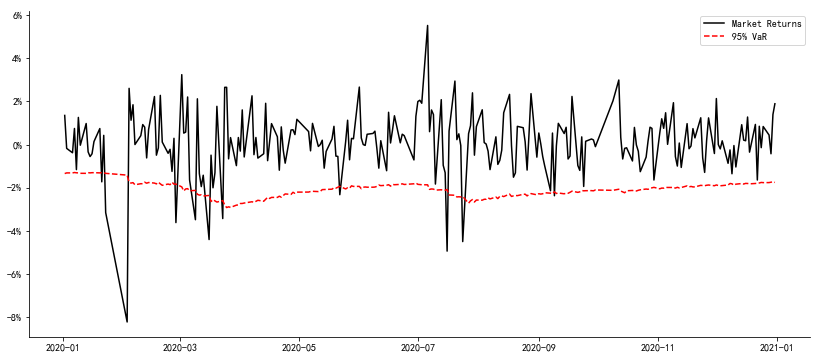

In [38]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df_year.index,df_year['Market Returns'],color='k',label='Market Returns')
ax.plot(df_year.index,-df_year['VaR'],color='r',linestyle='--',label='95% VaR')


def to_percent(temp, position):
    return '%1.0f'%(100*temp) + '%'

plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)
ax.legend()
plt.show()

fig.savefig('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\figures\\Market Returns and VaR of 2020.pdf',bb_inches='tight')

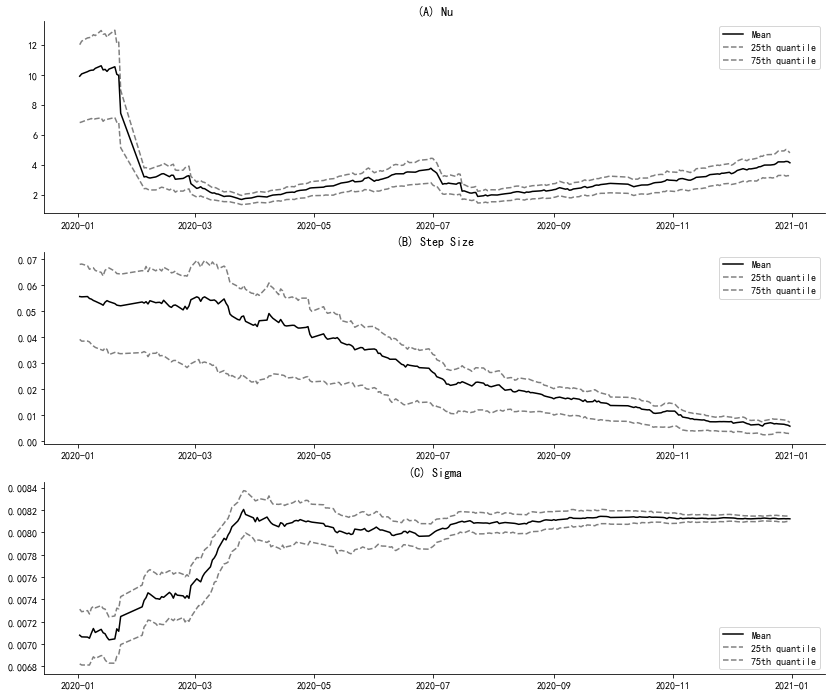

In [68]:
quantile_25=lambda x:np.quantile(x,0.25)
quantile_75=lambda x:np.quantile(x,0.75)

fig, ax = plt.subplots(3,1,figsize=(14, 12))
item=[nu_path_year,step_size_path_year,log_sigma_path_year]

for index,ii in enumerate(item):
    if index<2:
        ax[index].plot(ii.apply(np.mean).index,ii.apply(np.mean),color='k',label='Mean')
        ax[index].plot(ii.apply(quantile_25).index,ii.apply(quantile_25),color='k',alpha=0.5,linestyle='--',label='25th quantile')
        ax[index].plot(ii.apply(quantile_75).index,ii.apply(quantile_75),color='k',alpha=0.5,linestyle='--',label='75th quantile')
        ax[index].spines['top'].set_visible(False) 
        ax[index].spines['right'].set_visible(False)
        ax[index].legend()
    else:
        ii=np.exp(ii)
        ax[index].plot(ii.apply(np.mean).index,ii.apply(np.mean),color='k',label='Mean')
        ax[index].plot(ii.apply(quantile_25).index,ii.apply(quantile_25),color='k',alpha=0.5,linestyle='--',label='25th quantile')
        ax[index].plot(ii.apply(quantile_75).index,ii.apply(quantile_75),color='k',alpha=0.5,linestyle='--',label='75th quantile')
        ax[index].spines['top'].set_visible(False) 
        ax[index].spines['right'].set_visible(False)
        ax[index].legend(loc='lower right')

ax[0].set_title('(A) Nu')
ax[1].set_title('(B) Step Size')
ax[2].set_title('(C) Sigma')

plt.show()

fig.savefig('C:\\Users\\Lenovo\\Desktop\\PHBS\\研三\\Thesis\\NUS Thesis\\figures\\Posterior Distributions of Parameters in 2020.pdf',bb_inches='tight')